# Reservoir computing

Here we try to improve the prediction of model on experimental data by using pre-trained AMNWt. This model is pre-trained on simulated data created by using cobra solver. We use this on two pair of dataset. Fist on e_coli, we use e_coli_core_UB as simulated dataset and iML1515_EXP_UB as experimental dataset. Then on P.putida, we use IJN1463_10_UB as simulated dataset and IJN1463_EXP_UB_Anne.

In [20]:
SAVE_FIGURES = False

In [2]:
# E_coli
dataset_file_simulated = "./Dataset/e_coli_core_UB.npz"
objective_simulated=['BIOMASS_Ecoli_core_w_GAM']
dataset_file_experimental = "./Dataset/iML1515_EXP_UB.npz"
objective_experimental=['BIOMASS_Ec_iML1515_core_75p37M']
model_file_simulated = "Models/AMNWt_e_coli_core_UB.keras"

drop_out_rate = 0.2

batch_size = 7
epochs = 2000

In [2]:
# P.putida
dataset_file_simulated = "./Dataset/IJN1463_10_UB.npz"
objective_simulated=['BIOMASS_KT2440_WT3']
dataset_file_experimental = "./Dataset/IJN1463_EXP_UB_Anne.npz"
objective_experimental=['BIOMASS_KT2440_WT3']
model_file_simulated = "Models/AMNWt_IJN1463_10_UB.keras"

# no drop out
drop_out_rate = 0

batch_size = 30
epochs = 100

## Load the pre-trained model and simulated dataset information

In [3]:
import tensorflow as tf
from aMNWtModel import AMNWtModel, RNNCell

model_class = AMNWtModel
seed = 10
tf.random.set_seed(seed)


model_simulated = model_class(dataset_file=dataset_file_simulated, 
                   objective=objective_simulated,
                   timestep=4,
                   hidden_dim=50,
                   epochs=50, 
                   verbose=True,
                   batch_size=7)


model_simulated.train_test_split(test_size=0.1, random_state=seed)

# Preprocessing
from tools import MaxScaler
scaler= MaxScaler()
model_simulated.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_simulated.preprocessing_for_specific_model()


from tools import custom_loss
AMNWt_model = tf.keras.models.load_model(model_file_simulated, 
                                          custom_objects={"RNNCell":RNNCell,
                                                          "my_mse":custom_loss(model_simulated.S, 
                                                                               model_simulated.P_out,
                                                                               model_simulated.P_in)}
                                          )

print("R2 :", model_simulated.R2(model_simulated.Y_train, AMNWt_model.predict(model_simulated.X_train)))
print("Q2 :", model_simulated.R2(model_simulated.Y_test, AMNWt_model.predict(model_simulated.X_test)))

number of metabolites:  1617
filtered measurements size:  1
100.0


2023-10-18 11:50:06.966405: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 11:50:06.967953: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-10-18 11:50:07.352353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


R2 : 0.7816972835567102
Q2 : 0.7742851205067021


## Load the experimental data

In [4]:
import tensorflow as tf
from aMNWtModel import AMNWtModel


model_class = AMNWtModel
seed = 10 
# seed = 20
tf.random.set_seed(seed)


print("---------------------------------------- model ----------------------------------------")
model_experimental = model_class(dataset_file=dataset_file_experimental, 
                   objective=objective_experimental,
                   timestep=4,
                #    n_hidden=1, 
                   hidden_dim=50,
                   epochs=50, 
                   verbose=True,
                   batch_size=7)

# Preprocessing
model_experimental.train_test_split(test_size=0.1, random_state=seed)
from tools import MaxScaler
scaler= MaxScaler()
model_experimental.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_experimental.preprocessing_for_specific_model()

---------------------------------------- model ----------------------------------------
number of metabolites:  2153
filtered measurements size:  1
10.0


## Add a layer to old pre-trained model and fix model weights

In [5]:

from tensorflow.keras import Model, Input, layers

input_size_exp = model_experimental.X.shape[1]
input_size_sim = model_simulated.X.shape[1]


sub_model = AMNWt_model
sub_model.trainable = False
drop_out = layers.Dropout(drop_out_rate, input_shape=(input_size_sim,))
layer = layers.Dense(input_size_sim,activation='relu')

inputs = Input((input_size_exp))
x = layer(drop_out(inputs))
y = sub_model(x)
new_model = Model(inputs=inputs, 
                  outputs=y)
new_model.compile(optimizer='adam',
              loss=custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in),
              metrics=None)

## Train/test on experimental data

In [6]:
# Fit on experimental dataset
history = new_model.fit(model_experimental.X_train, model_experimental.Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

R_2 = model_simulated.R2(model_experimental.Y_train, new_model.predict(model_experimental.X_train))
Q_2 = model_simulated.R2(model_experimental.Y_test, new_model.predict(model_experimental.X_test))
print("R2 :", R_2)
print("Q2 :", Q_2)

R2 : 0.5420535394196715
Q2 : 0.5341304242842286


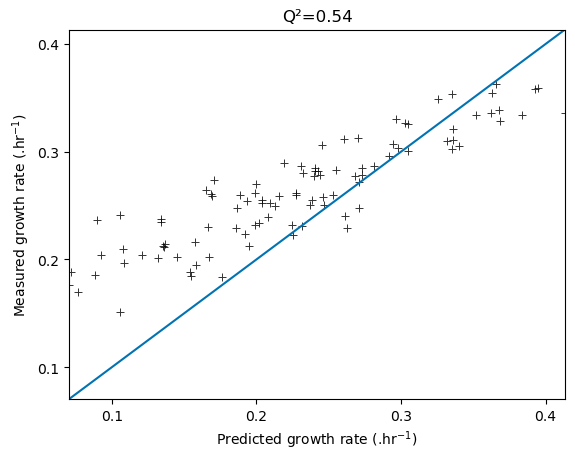

In [7]:
from tools import plot_regression
import numpy as np

TRUE = model_experimental.Y_train[:,0]

pred =  new_model.predict(model_experimental.X_train)
P_out     = tf.convert_to_tensor(np.float32(model_simulated.P_out))   
PRED = tf.linalg.matmul(pred[:,:model_simulated.S.shape[1]], tf.transpose(P_out)) 

if SAVE_FIGURES:
    figure_file = "Figure/e_coli_reservoir_AMNWt_train.png"
else:
    figure_file = None

plot_regression(PRED, 
                TRUE, 
                "Measured growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Predicted growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Q²="+str(round(R_2, 2)),
                figure_file)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


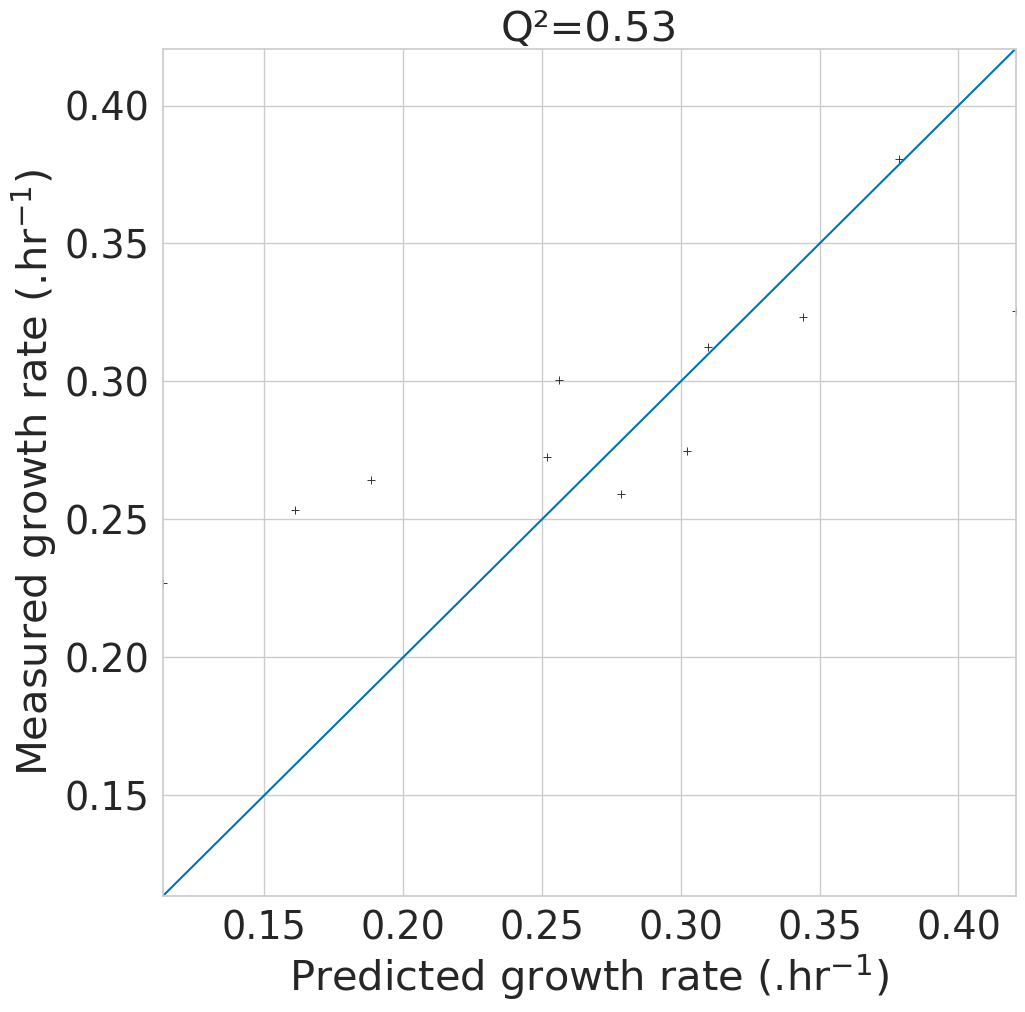

In [8]:
from tools import plot_regression
import numpy as np

TRUE = model_experimental.Y_test[:,0]

pred =  new_model.predict(model_experimental.X_test)
P_out     = tf.convert_to_tensor(np.float32(model_simulated.P_out))   
PRED = tf.linalg.matmul(pred[:,:model_simulated.S.shape[1]], tf.transpose(P_out)) 

if SAVE_FIGURES:
    figure_file = "Figure/e_coli_reservoir_AMNWt_test.png"
else:
    figure_file = None

plot_regression(PRED, 
                TRUE, 
                "Measured growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Predicted growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Q²="+str(round(Q_2, 2)),
                figure_file)
                # "Figure/biolog_iML1515_EXP_UB_AMNWt_" + str(epoch) +"_"+ str(batch_size) +"_regression.png")

## On all experimental dataset

Since the result depends on the train/test splitting we try to get the score on all the dataset.

In [6]:
import numpy as np
scaler= MaxScaler()

X = scaler.fit_transform(model_experimental.X)
Y = np.concatenate((model_experimental.Y, np.zeros((len(model_experimental.Y),3))), axis=1)

# Shuffle dataset
idx = np.arange(len(X))
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]

In [7]:
from tensorflow.keras.layers import Dropout
 
# reset the model
inputs = Input((input_size_exp))

drop_out = Dropout(drop_out_rate, input_shape=(input_size_sim,))

layer = layers.Dense(input_size_sim,activation='relu')

x = layer(drop_out(inputs))
x = layer(inputs)
y = sub_model(x)
new_model = Model(inputs=inputs, 
                  outputs=y)
new_model.compile(optimizer='adam',
              loss=custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in),
              metrics=None)
history = new_model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=0)
R_2 = model_simulated.R2(Y, new_model.predict(X))
print("R2 :", R_2)

R2 : 0.6762935900473586


In [8]:

TRUE = Y[:,0]

pred =  new_model.predict(X)
P_out     = tf.convert_to_tensor(np.float32(model_simulated.P_out))   
PRED = tf.linalg.matmul(pred[:,:model_simulated.S.shape[1]], tf.transpose(P_out)) 

/home/agiralt/anaconda3/envs/AMN/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


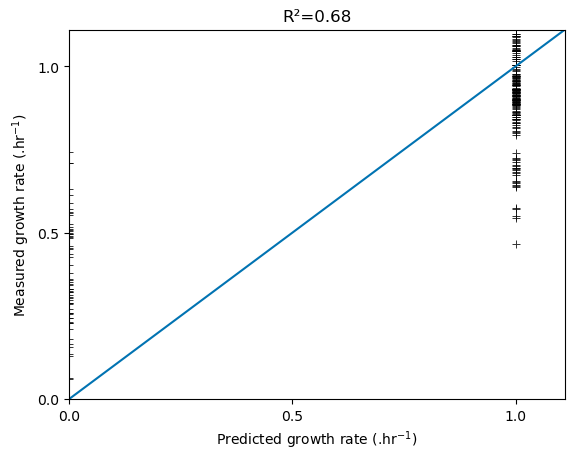

In [9]:
from tools import plot_regression
plot_regression(PRED, 
                TRUE, 
                "Measured growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Predicted growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "R²="+str(round(R_2, 2)),)

## Classification

This part is for P.putida only; the dataset is label 0 or 1 for growth no-growth so we threshold the result of trained regression to get classification result. We also give accuracy result for the different sub-dataset corresponding to the carbon and nitrogen source replacement.

In [10]:
PRED_ = np.array(PRED)
max = PRED_.max()
percentage = 0.5
PRED_t = PRED_ >= max*percentage
PRED_tresholded = PRED_t.astype(int)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


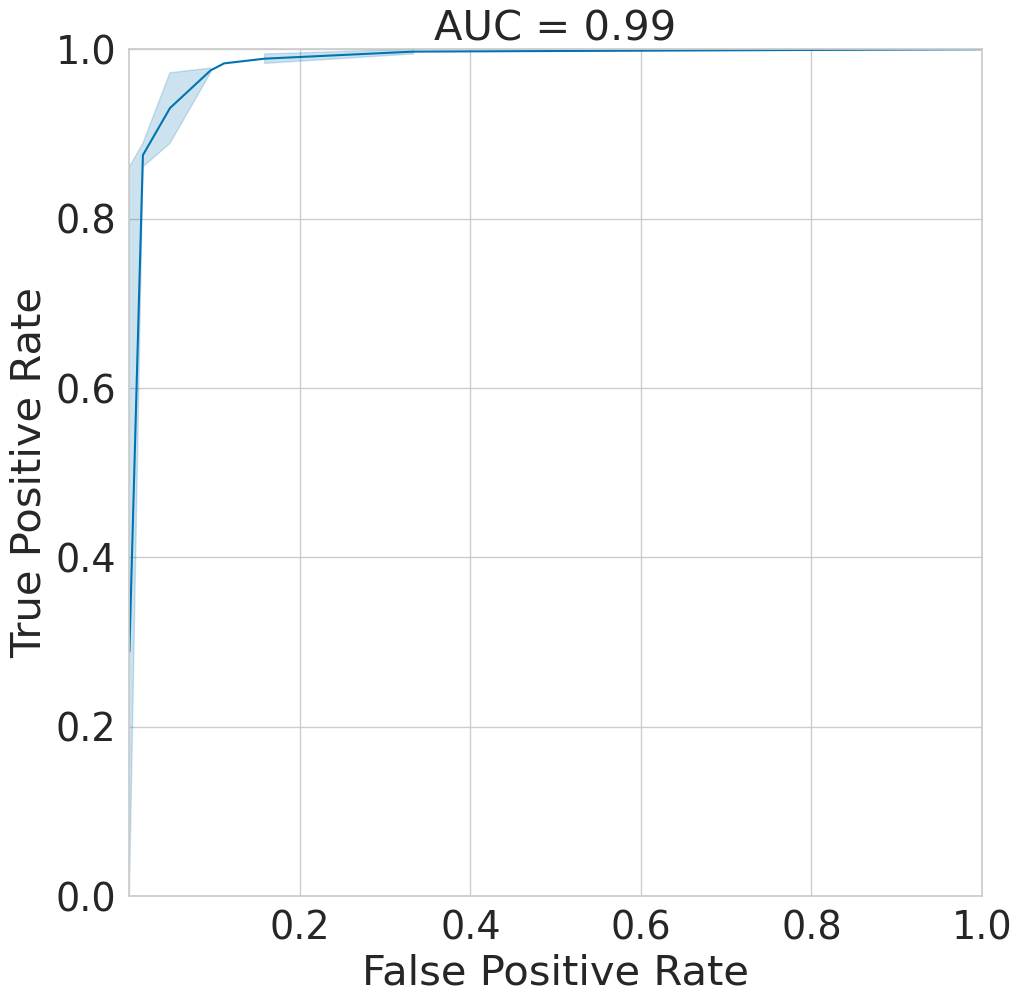

In [11]:
from tools import plot_classification
plot_classification(PRED, TRUE)

In [12]:
from sklearn.metrics import accuracy_score
all_accuracy = accuracy_score(PRED_tresholded, TRUE)

In [13]:
nitrogen = X[:,22] == 0 
carbon = X[:,15] ==0

nitrogen_index = [i for (i, bool) in enumerate(nitrogen) if bool]
carbon_index = [i for (i, bool) in enumerate(carbon) if bool]

X[carbon_index].shape
Y[carbon_index].shape

carbon_accuracy = accuracy_score(PRED_tresholded[carbon_index] , TRUE[carbon_index])
nitrogen_accuracy = accuracy_score(PRED_tresholded[nitrogen_index] , TRUE[nitrogen_index])

All accuracy : 0.95
Carbon : 0.95
Nitrogen : 0.95


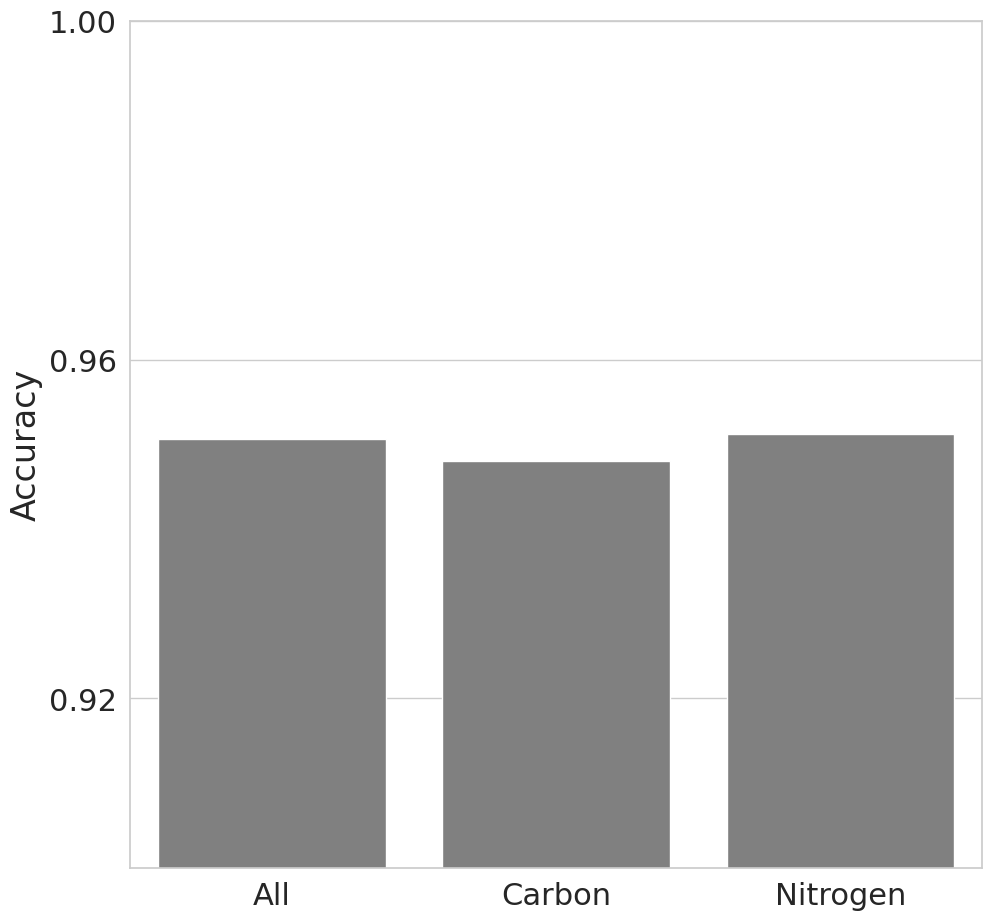

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt



condition = ["All", "Carbon", "Nitrogen"]
acc_fit_AMN = [all_accuracy, carbon_accuracy, nitrogen_accuracy]
# acc_fit_AMN = (all_accuracy, carbon_accuracy, nitrogen_accuracy)

print("All accuracy : %.2f\nCarbon : %.2f\nNitrogen : %.2f" %(all_accuracy, carbon_accuracy, nitrogen_accuracy))

sns.set_theme(style='whitegrid', font='arial', font_scale=2, palette='colorblind')
sns.barplot(x=condition, y=acc_fit_AMN, color="grey")
# plt.errorbar(x = condition, y = acc_fit_AMN, yerr=std_fit_AMN, fmt='none', c='orange', capsize = 2)
plt.yticks([0.92, 0.96, 1.00])
plt.ylabel("Accuracy")
plt.ylim(0.9, 1)
# plt.savefig("Figures/Fig5E."+FORMAT, format=FORMAT, dpi=800, bbox_inches = 'tight')
if SAVE_FIGURES:
    plt.savefig("Figure/Putida_accuracy_all_carbon_nitrogen", format="png", dpi=800, bbox_inches = 'tight')
plt.show()
plt.close('all')

## The dataset splitting have a big influence on result

We compute Q² score for different train/test split. Since the dataset is not large the seed for splitting have an influence on the score. The drop out helps a lot.

In [36]:
for i in range(10):
   seed = 10+i
   print("seed : ",seed)
   tf.random.set_seed(seed)
   dataset_file = "./Dataset/iML1515_EXP_UB.npz"
   objective=['BIOMASS_Ec_iML1515_core_75p37M']
   uptake_max_index=None

   print("---------------------------------------- model ----------------------------------------")
   model_experimental = model_class(dataset_file=dataset_file, 
                      objective=objective,
                      timestep=4,
                   #    n_hidden=1, 
                      hidden_dim=50,
                      epochs=50, 
                      verbose=True,
                      batch_size=7,
                      uptake_max_index = uptake_max_index)
   
   # Preprocessing
   model_experimental.train_test_split(test_size=0.1, random_state=seed)
   # if RESCALE:
   from tools import MaxScaler
   scaler= MaxScaler()
   model_simulated.preprocess(scaler)
   model_experimental.preprocessing_for_specific_model()


   inputs = Input((input_size_exp))

   drop_out = Dropout(drop_out_rate, input_shape=(input_size_sim,))

   layer = layers.Dense(input_size_sim,activation='relu')

   x = layer(drop_out(inputs))
   # x = layer(inputs)
   y = sub_model(x)
   new_model = Model(inputs=inputs, 
                     outputs=y)
   new_model.compile(optimizer='adam',
                 loss=custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in),
                 metrics=None)

   
   history = new_model.fit(model_experimental.X_train, model_experimental.Y_train, epochs=1500, batch_size=7, verbose=0)

   R_2 = model_simulated.R2(model_experimental.Y_train, new_model.predict(model_experimental.X_train))
   Q_2 = model_simulated.R2(model_experimental.Y_test, new_model.predict(model_experimental.X_test))
   print("R2 :", R_2)
   print("Q2 :", Q_2)



seed :  10
---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
R2 : 0.5348772816182747
Q2 : 0.4971939090730698
seed :  11
---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
R2 : 0.5013561082042945
Q2 : 0.4395326421761595
seed :  12
---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
R2 : 0.4986576884057467
Q2 : 0.2311002627338562
seed :  13
---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1


KeyboardInterrupt: 

## Using cobra with output of the new_model as input

TensorShape([11, 20])

In [13]:
import cobra
from run_cobra import run_cobra

result_cobra_test = None

cobra_model = cobra.io.read_sbml_model("Dataset/iML1515_EXP_UB.xml")
Y = []
for i in range(X.shape[0]):

    inf = {r.id: 0 for r in cobra_model.reactions}
    ## Reaction must be linked to e_coli_model
    for j in range(X.shape[1]):
        inf[model_simulated.medium[j]] = X[i,j]
        if i==0:
            [print(i) for i in inf.items() if i[1]!=0]
    result = run_cobra(cobra_model, ["BIOMASS_Ec_iML1515_core_75p37M"], inf)
    result_cobra_test = result        
    Y.append(result[1])


('EX_glc__D_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=2.0606725>)
('EX_h_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=1.1056113>)
('EX_glc__D_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=2.0606725>)
('EX_h_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=1.1056113>)
('EX_h2o_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=1.2233881>)
('EX_glc__D_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=2.0606725>)
('EX_h_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=1.1056113>)
('EX_h2o_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=1.2233881>)
('EX_glc__D_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=2.0606725>)
('EX_h_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=1.1056113>)
('EX_h2o_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=1.2233881>)
('EX_o2_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=2.486182>)
('EX_glc__D_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=2.0606725>)
('EX_pi_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=0.61405927>)
('EX_h_e_i', <t

/home/agiralt/anaconda3/envs/AMN/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [14]:
Y

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [15]:
[print(i) for i in result_cobra_test[0].items() if i[1]!=0]

('H2Otex_i', 1.2157361507415771)
('H2Otpp_i', 1.2157361507415771)
('ATPM', 6.86)
('EX_h2o_e_i', 1.2157361507415771)
('EX_glc__D_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=2.15141>)
('EX_etoh_e_i', <tf.Tensor: shape=(), dtype=float32, numpy=18.258532>)


[None, None, None, None, None, None]

In [74]:
result_cobra_test[1]

0.0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_regression(pred, true, pred_label, true_label, title, saving_file=None):
    plt.title(title)
    sns.set(font='arial', palette="colorblind", style="whitegrid", font_scale=2.5, rc={'figure.figsize':(11,11)})
    sns.regplot(x=true, y=pred, fit_reg=0, marker='+', color='black', scatter_kws={'s':40, 'linewidths':0.7})
    plt.xlabel(true_label)
    plt.ylabel(pred_label)
    
    p1 = max(max(pred), max(true))
    p2 = min(min(pred), min(true))
    
    plt.xlim(p1, p2)
    plt.ylim(p1, p2)
    plt.plot([p1, p2], [p1, p2], 'b-')

    if saving_file:
        plt.savefig(saving_file, format="png", dpi=600, bbox_inches='tight')
    plt.show()
    plt.close("all")


In [ ]:
import cobra
from run_cobra import run_cobra


cobra_model = cobra.io.read_sbml_model("Dataset/iML1515_EXP_UB.xml")
Y = []
for i in range(model_.X_test.shape[0]):
    y = []

    inf = {r.id: 0 for r in cobra_model.reactions}
    ## Reaction must be linked to e_coli_model
    for j in range(len(model_.medium)):
        inf[model_.medium[j]] = model_.X_test[i,j]
        result = run_cobra(cobra_model, ["BIOMASS_Ec_iML1515_core_75p37M"], inf)
        y.append(result[1])
    Y.append(y)

In [ ]:
PRED_ = np.array(PRED)
max = PRED_.max()

for i in range(100):
    percentage = i/100
    PRED_t = PRED_ >= max*percentage
    PRED_tresholded = PRED_t.astype(int)
    print(i, accuracy_score(PRED_tresholded, TRUE))

0 0.7293577981651376
1 0.7293577981651376
2 0.7293577981651376
3 0.7339449541284404
4 0.7339449541284404
5 0.7339449541284404
6 0.7339449541284404
7 0.7431192660550459
8 0.7522935779816514
9 0.7568807339449541
10 0.7660550458715596
11 0.7752293577981652
12 0.7798165137614679
13 0.7798165137614679
14 0.7844036697247706
15 0.7889908256880734
16 0.8027522935779816
17 0.8073394495412844
18 0.8256880733944955
19 0.8256880733944955
20 0.8532110091743119
21 0.8669724770642202
22 0.8669724770642202
23 0.8761467889908257
24 0.8807339449541285
25 0.8853211009174312
26 0.8853211009174312
27 0.8899082568807339
28 0.8899082568807339
29 0.8944954128440367
30 0.908256880733945
31 0.908256880733945
32 0.908256880733945
33 0.908256880733945
34 0.908256880733945
35 0.908256880733945
36 0.908256880733945
37 0.908256880733945
38 0.908256880733945
39 0.908256880733945
40 0.9128440366972477
41 0.9174311926605505
42 0.9220183486238532
43 0.926605504587156
44 0.9357798165137615
45 0.9495412844036697
46 0.9495